In [1]:
import torch
x = torch.ones(2, 2, requires_grad = True)
y = x + 1
print(x)
print(y)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)


In [2]:
z = 2*y**2
z

tensor([[8., 8.],
        [8., 8.]], grad_fn=<MulBackward0>)

In [3]:
r = z.mean()
r

tensor(8., grad_fn=<MeanBackward0>)

In [4]:
r.backward()
print(x.grad)

tensor([[2., 2.],
        [2., 2.]])


-----------------

In [5]:
x = torch.FloatTensor(range(5))
print(x)
x.size()

tensor([0., 1., 2., 3., 4.])


torch.Size([5])

In [6]:
x = torch.FloatTensor(range(5)).unsqueeze(1)
print(x)
x.size()

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])


torch.Size([5, 1])

In [7]:
y = 2*x + torch.rand(5,1)
y

tensor([[0.4181],
        [2.6271],
        [4.4810],
        [6.8161],
        [8.0291]])

In [8]:
num_features = x.shape[1]
num_features

1

In [9]:
w = torch.randn(num_features, 1, requires_grad = True)
b = torch.randn(1, requires_grad = True)

In [10]:
w

tensor([[0.5918]], requires_grad=True)

In [11]:
b

tensor([1.4508], requires_grad=True)

In [12]:
learning_rate = 1e-3
optimizer = torch.optim.SGD([w, b], lr = learning_rate)

In [13]:
loss_stack = []
for epoch in range(1001):
    optimizer.zero_grad()
    y_hat = torch.matmul(x, w) + b
    loss = torch.mean((y_hat - y) ** 2)
    loss.backward()
    optimizer.step()
    loss_stack.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4}, loss : {loss.item():.4f}")

Epoch    0, loss : 7.0885
Epoch  100, loss : 0.9209
Epoch  200, loss : 0.4624
Epoch  300, loss : 0.3929
Epoch  400, loss : 0.3540
Epoch  500, loss : 0.3209
Epoch  600, loss : 0.2917
Epoch  700, loss : 0.2658
Epoch  800, loss : 0.2428
Epoch  900, loss : 0.2223
Epoch 1000, loss : 0.2042


In [14]:
print(w, b)

tensor([[1.7122]], requires_grad=True) tensor([1.2445], requires_grad=True)


In [15]:
with torch.no_grad():
    y_hat = torch.matmul(x, w) + b

In [16]:
loss_stack[:10]

[7.088475227355957,
 6.913358211517334,
 6.74289083480835,
 6.5769476890563965,
 6.415408134460449,
 6.2581562995910645,
 6.105077266693115,
 5.956060886383057,
 5.810996055603027,
 5.669780731201172]

In [17]:
import matplotlib.pyplot as plt

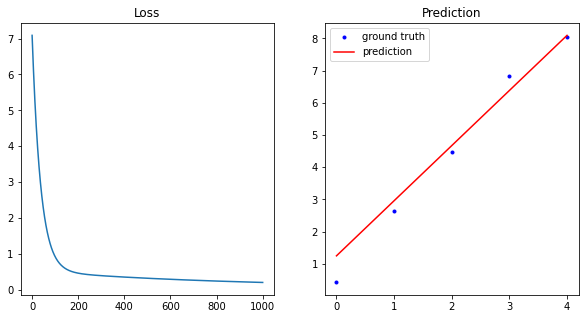

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")

plt.subplot(122)
plt.plot(x, y, '.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth','prediction'])
plt.title("Prediction")
plt.show()

In [19]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [20]:
transf = tr.Compose([tr.Resize(16), tr.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transf)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transf)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [21]:
print(trainset[0][0].size())

torch.Size([3, 16, 16])


In [22]:
trainloader = DataLoader(trainset, batch_size = 50, shuffle = True)
testloader = DataLoader(testset, batch_size = 50, shuffle = True)

In [23]:
images, labels = next(iter(trainloader))
print(images.size())

torch.Size([50, 3, 16, 16])


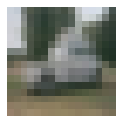

In [24]:
plt.figure(figsize=(2, 2))
oneshot = images[1].permute(1, 2, 0).numpy()
plt.imshow(oneshot)
plt.axis('off')
plt.show()

In [80]:
train_images = np.random.randint(256, size=(100, 32, 32, 3)) / 255
train_labels = np.random.randint(2, size=(100,1))
print(train_images.shape)
print(train_labels.shape)

(100, 32, 32, 3)
(100, 1)


In [29]:
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.x_data = self.x_data.permute(0,3,1,2)

        self.y_data = torch.LongTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return self.len

In [31]:
train_data = TensorData(train_images, train_labels)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

In [ ]:
next(iter(train_loader))

In [81]:
class ToTensor:
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2, 0, 1)
        return inputs, torch.LongTensor(labels)

In [82]:
class CutOut:
    def __init__(self, ratio=0.5):
        self.ratio = int(1/ratio)

    def __call__(self, sample):
        inputs, labels = sample
        active = int(np.random.randint(0, self.ratio, 1))

        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len // 4)
            idx = int(np.random.randint(0, min_len - box_size, 1))
            inputs[:, idx : idx + box_size, idx : idx + box_size] = 0

        return inputs, labels

In [83]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data, transform = None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()

    def __getitem__(self,idx):
        sample = self.x_data[idx], self.y_data[idx]

        if self.transform:
            sample = self.transform(sample)

        else:
            sample = self.tensor(sample)

        return sample

    def __len__(self):
        return self.len

In [96]:
trans = tr.Compose([ToTensor(), CutOut()])
dataset1 = MyDataset(train_images, train_labels, transform = trans)
train_loader1 = DataLoader(dataset1, batch_size = 10, shuffle = True)

In [97]:
import torchvision
images1, labels1 = next(iter(train_loader1))

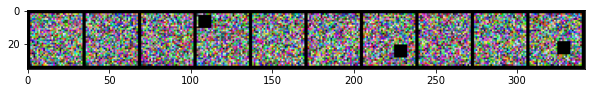

In [98]:
def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()

imshow(torchvision.utils.make_grid(images1, nrow=10))

In [99]:
class MyTransform:

    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2, 0, 1)
        labels = torch.FloatTensor(labels)

        transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])
        final_output = transf(inputs)

        return final_output, labels

In [100]:
dataset2 = MyDataset(train_images, train_labels, transform=MyTransform())
train_loader2 = DataLoader(dataset2, batch_size = 10, shuffle = True)

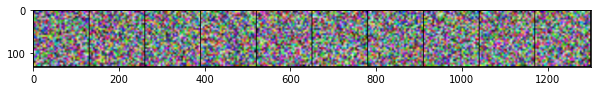

In [101]:
images2, labels2 = next(iter(train_loader2))
imshow(torchvision.utils.make_grid(images2, nrow=10))

In [102]:
class CutOut:
    def __init__(self, ratio=0.5):
        self.ratio = int(1/ratio)

    def __call__(self, inputs):
        active = int(np.random.randint(0, self.ratio, 1))

        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len // 4)
            idx = int(np.random.randint(0, min_len - box_size, 1))
            inputs[:, idx : idx + box_size, idx : idx + box_size] = 0

        return inputs

Files already downloaded and verified


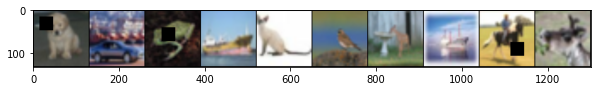

torch.Size([10, 3, 128, 128])


In [104]:
transf = tr.Compose([tr.Resize(128), tr.ToTensor(), CutOut()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)
trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images, nrow=10))
print(images.size())